# Step 4: Training and Validation

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
COMBINED_PATH = BASE_PATH / 'data' / 'processed' / 'combined'
OUTPUT_PATH = BASE_PATH / 'outputs' / 'tables'
FIGURES_PATH = BASE_PATH / 'outputs' / 'figures'
MODELS_PATH = BASE_PATH / 'outputs' / 'models'
CONFUSION_PATH = FIGURES_PATH / 'confusion_matrices'
MODELS_PATH.mkdir(parents=True, exist_ok=True)
CONFUSION_PATH.mkdir(parents=True, exist_ok=True)

In [2]:
# 4.1 Data Preparation
df = pd.read_csv(COMBINED_PATH / 'combined_dataset_filled.csv')
print(f"Loaded: {len(df)} windows")

# Identify feature and metadata columns
metadata_cols = ['subject_id', 'dataset', 'window_id', 'timestamp_start', 'timestamp_end', 'label']
feature_cols = [c for c in df.columns if c not in metadata_cols]
print(f"Features: {len(feature_cols)}")
print(f"Labels: {df['label'].nunique()} classes")

Loaded: 10511 windows
Features: 39
Labels: 6 classes


In [3]:
# Prepare X and y
X = df[feature_cols].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"X shape: {X.shape}")
print(f"Classes: {le.classes_}")
print(f"\nClass distribution:")
for i, cls in enumerate(le.classes_):
    print(f"  {cls}: {(y_encoded == i).sum()}")

X shape: (10511, 39)
Classes: ['Aerobic' 'Amusement' 'Anaerobic' 'Baseline' 'Emotion' 'Stress']

Class distribution:
  Aerobic: 2143
  Amusement: 209
  Anaerobic: 1620
  Baseline: 707
  Emotion: 2510
  Stress: 3322


In [4]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler
joblib.dump(scaler, MODELS_PATH / 'feature_scaler.pkl')
print("Features standardized and scaler saved")

Features standardized and scaler saved


In [7]:
# 4.2 Define models to train (GPU-enabled where supported)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, tree_method='hist', device='cuda', eval_metric='mlogloss'),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

print(f"Models to train: {len(models)}")
for name in models:
    print(f"  - {name}")
print("\nGPU enabled for: XGBoost")

Models to train: 8
  - Logistic Regression
  - Decision Tree
  - KNN
  - SVM
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - MLP

GPU enabled for: XGBoost


In [8]:
# 4.2 Train and evaluate models with 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=cv, scoring='accuracy')
    
    # Fit final model on all data for feature importance and saving
    model.fit(X_scaled, y_encoded)
    
    train_time = time.time() - start_time
    
    # Get predictions for metrics
    y_pred = model.predict(X_scaled)
    
    results.append({
        'model': name,
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std(),
        'train_accuracy': accuracy_score(y_encoded, y_pred),
        'precision_weighted': precision_score(y_encoded, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_encoded, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_encoded, y_pred, average='weighted'),
        'training_time': train_time
    })
    
    # Save model
    joblib.dump(model, MODELS_PATH / f'{name.lower().replace(" ", "_")}.pkl')
    
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Training time: {train_time:.2f}s")


Training Logistic Regression...
  CV Accuracy: 0.6318 (+/- 0.0074)
  Training time: 1.05s

Training Decision Tree...
  CV Accuracy: 0.8066 (+/- 0.0062)
  Training time: 1.90s

Training KNN...
  CV Accuracy: 0.8360 (+/- 0.0037)
  Training time: 0.07s

Training SVM...
  CV Accuracy: 0.7801 (+/- 0.0142)
  Training time: 38.59s

Training Random Forest...
  CV Accuracy: 0.9313 (+/- 0.0070)
  Training time: 2.30s

Training Gradient Boosting...
  CV Accuracy: 0.8593 (+/- 0.0081)
  Training time: 255.72s

Training XGBoost...
  CV Accuracy: 0.9513 (+/- 0.0040)
  Training time: 4.03s

Training MLP...
  CV Accuracy: 0.8902 (+/- 0.0133)
  Training time: 30.35s


In [9]:
# Save model comparison results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('cv_accuracy_mean', ascending=False)
results_df.to_csv(OUTPUT_PATH / 'model_comparison_results.csv', index=False)

print("\nModel Comparison Results:")
print(results_df[['model', 'cv_accuracy_mean', 'cv_accuracy_std', 'f1_weighted', 'training_time']].to_string(index=False))


Model Comparison Results:
              model  cv_accuracy_mean  cv_accuracy_std  f1_weighted  training_time
            XGBoost          0.951289         0.003986     1.000000       4.029044
      Random Forest          0.931310         0.006984     1.000000       2.304177
                MLP          0.890211         0.013264     1.000000      30.345878
  Gradient Boosting          0.859290         0.008130     0.921307     255.721593
                KNN          0.835982         0.003663     0.914444       0.072398
      Decision Tree          0.806583         0.006159     1.000000       1.896027
                SVM          0.780135         0.014203     0.812728      38.591263
Logistic Regression          0.631815         0.007403     0.629419       1.052398


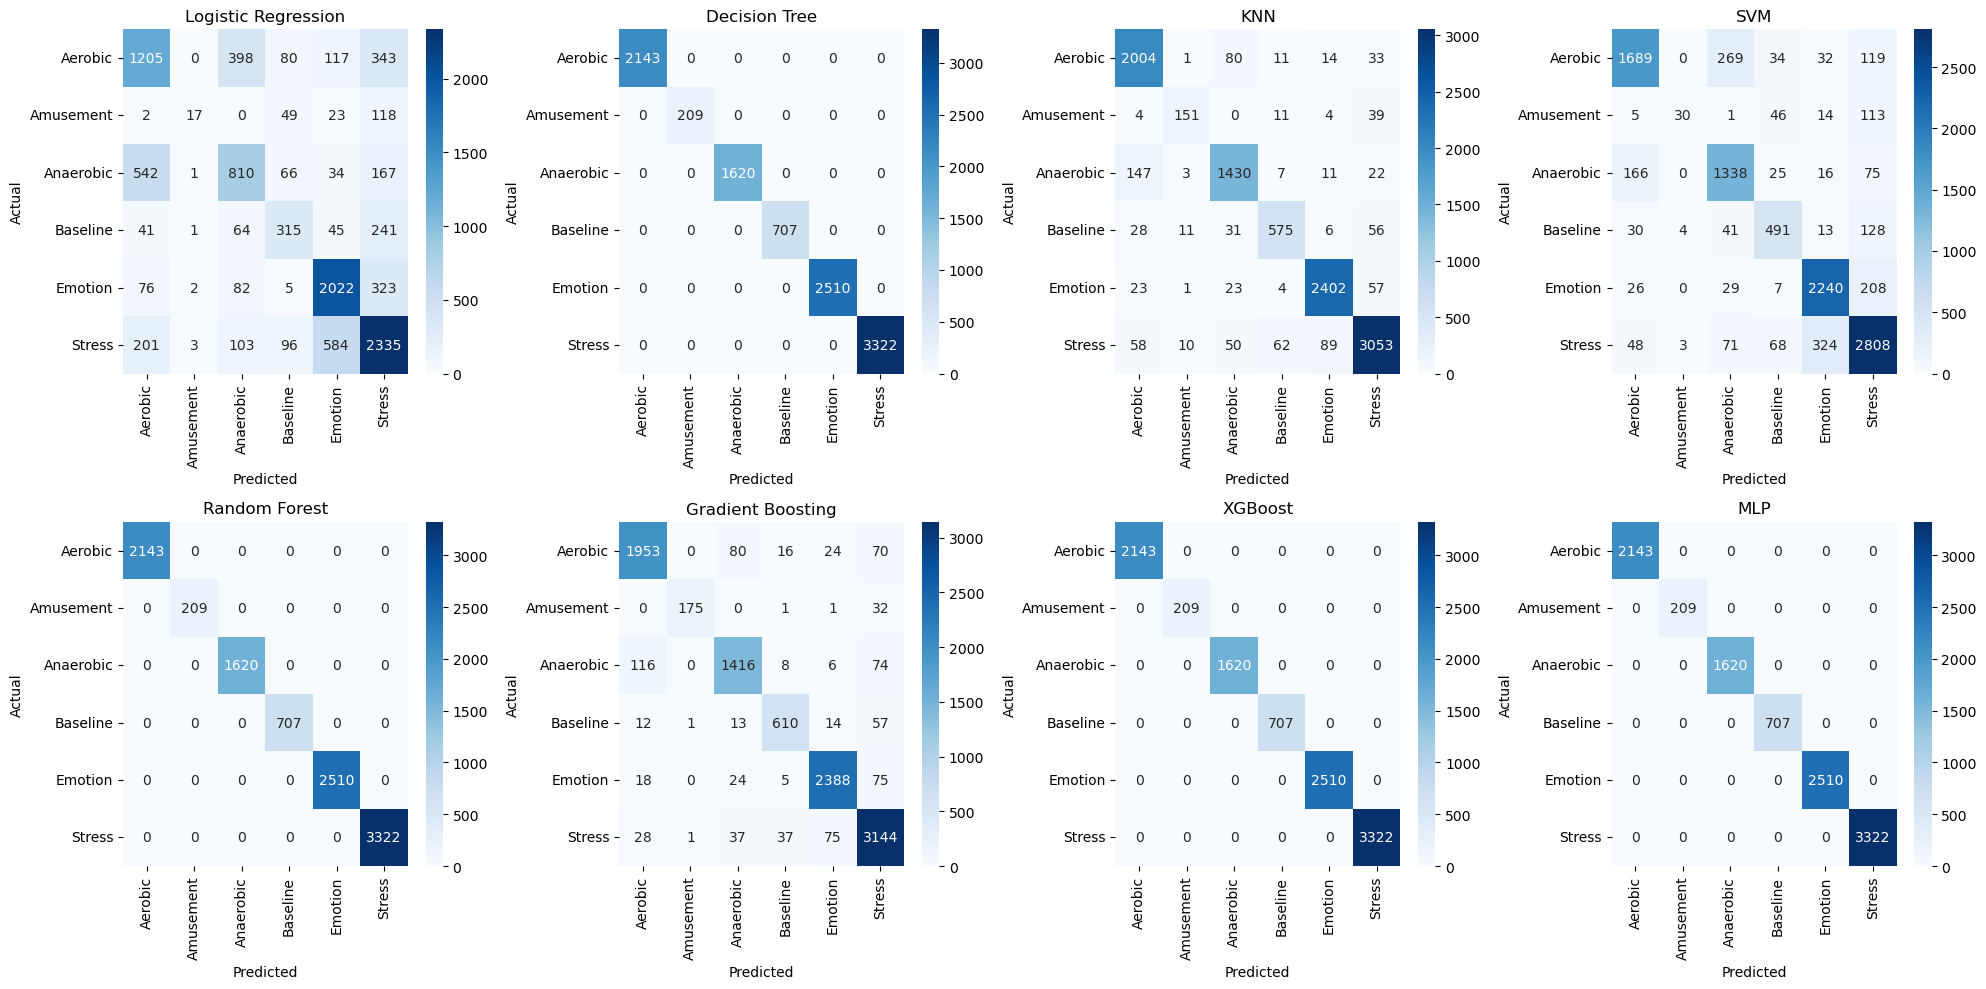

Saved: /home/alvaro-ibarra/smartwatch-stress-detection/outputs/figures/confusion_matrices/all_models_confusion.png


In [10]:
# Generate confusion matrices for all models
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    # Load saved model
    model = joblib.load(MODELS_PATH / f'{name.lower().replace(" ", "_")}.pkl')
    y_pred = model.predict(X_scaled)
    
    cm = confusion_matrix(y_encoded, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=le.classes_, yticklabels=le.classes_)
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(CONFUSION_PATH / 'all_models_confusion.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {CONFUSION_PATH / 'all_models_confusion.png'}")

In [11]:
# 4.3 Feature importance from best tree-based model
best_model_name = results_df.iloc[0]['model']
print(f"Best model: {best_model_name}")

# Get feature importance from Random Forest and XGBoost
rf_model = joblib.load(MODELS_PATH / 'random_forest.pkl')
xgb_model = joblib.load(MODELS_PATH / 'xgboost.pkl')

feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance_rf': rf_model.feature_importances_,
    'importance_xgb': xgb_model.feature_importances_
}).sort_values('importance_rf', ascending=False)

print("\nTop 15 features (RF):")
print(feature_importance_rf[['feature', 'importance_rf']].head(15).to_string(index=False))

Best model: XGBoost

Top 15 features (RF):
         feature  importance_rf
      acc_y_mean       0.091911
      acc_x_mean       0.074096
      acc_z_mean       0.050662
         acc_sma       0.050062
    acc_mag_mean       0.043176
     acc_mag_std       0.042075
      acc_energy       0.037900
       acc_y_std       0.033675
        temp_min       0.032140
        temp_max       0.030881
       temp_mean       0.030331
       acc_x_std       0.028499
     acc_mag_min       0.025434
 eda_phasic_mean       0.025371
eda_scr_amp_mean       0.022756


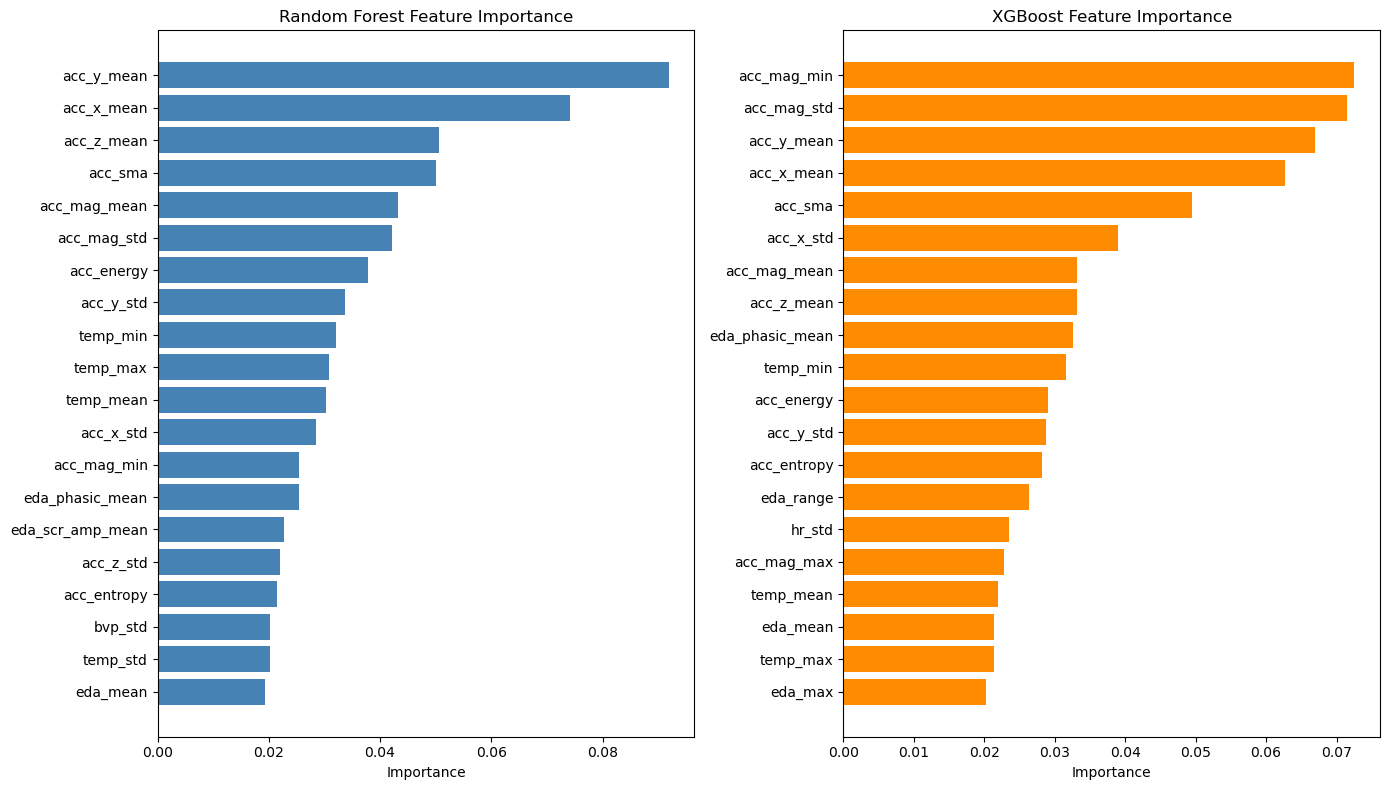

In [12]:
# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# RF importance
top_rf = feature_importance_rf.head(20)
axes[0].barh(range(len(top_rf)), top_rf['importance_rf'], color='steelblue')
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest Feature Importance')

# XGB importance
top_xgb = feature_importance_rf.sort_values('importance_xgb', ascending=False).head(20)
axes[1].barh(range(len(top_xgb)), top_xgb['importance_xgb'], color='darkorange')
axes[1].set_yticks(range(len(top_xgb)))
axes[1].set_yticklabels(top_xgb['feature'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost Feature Importance')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# 4.4 Leave-One-Subject-Out (LOSO) Validation
print("Starting LOSO validation...")
subjects = df['subject_id'].unique()
print(f"Total subjects: {len(subjects)}")

# Use top 3 models for LOSO (faster)
top_models = results_df.head(3)['model'].tolist()
print(f"Models for LOSO: {top_models}")

Starting LOSO validation...
Total subjects: 96
Models for LOSO: ['XGBoost', 'Random Forest', 'MLP']


In [14]:
# LOSO validation (GPU enabled for XGBoost)
loso_results = []

for model_name in top_models:
    print(f"\nLOSO for {model_name}...")
    subject_accuracies = []
    
    for i, test_subject in enumerate(subjects):
        # Split by subject
        train_mask = df['subject_id'] != test_subject
        test_mask = df['subject_id'] == test_subject
        
        X_train = X_scaled[train_mask]
        X_test = X_scaled[test_mask]
        y_train = y_encoded[train_mask]
        y_test = y_encoded[test_mask]
        
        if len(y_test) == 0:
            continue
            
        # Get fresh model (GPU for XGBoost)
        if model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=100, random_state=42, tree_method='hist', device='cuda', eval_metric='mlogloss')
        elif model_name == 'Gradient Boosting':
            model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        elif model_name == 'SVM':
            model = SVC(kernel='rbf', random_state=42)
        elif model_name == 'MLP':
            model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
        else:
            continue
            
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        subject_accuracies.append(acc)
        
        loso_results.append({
            'model': model_name,
            'subject_id': test_subject,
            'dataset': df.loc[test_mask, 'dataset'].iloc[0],
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
            'f1': f1_score(y_test, y_pred, average='weighted', zero_division=0)
        })
        
        if (i + 1) % 20 == 0:
            print(f"  Processed {i+1}/{len(subjects)} subjects")
    
    print(f"  Mean accuracy: {np.mean(subject_accuracies):.4f} (+/- {np.std(subject_accuracies):.4f})")


LOSO for XGBoost...
  Processed 20/96 subjects
  Processed 40/96 subjects
  Processed 60/96 subjects
  Processed 80/96 subjects
  Mean accuracy: 0.7242 (+/- 0.2372)

LOSO for Random Forest...
  Processed 20/96 subjects
  Processed 40/96 subjects
  Processed 60/96 subjects
  Processed 80/96 subjects
  Mean accuracy: 0.6890 (+/- 0.2354)

LOSO for MLP...
  Processed 20/96 subjects
  Processed 40/96 subjects
  Processed 60/96 subjects
  Processed 80/96 subjects
  Mean accuracy: 0.6615 (+/- 0.2353)


In [15]:
# Save LOSO results
loso_df = pd.DataFrame(loso_results)
loso_df.to_csv(OUTPUT_PATH / 'loso_results.csv', index=False)

# Summary per model
loso_summary = loso_df.groupby('model').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'f1': ['mean', 'std']
}).round(4)

print("\nLOSO Summary by Model:")
print(loso_summary)


LOSO Summary by Model:
              accuracy                        f1        
                  mean     std  min  max    mean     std
model                                                   
MLP             0.6615  0.2366  0.0  1.0  0.7172  0.2272
Random Forest   0.6890  0.2367  0.0  1.0  0.7333  0.2368
XGBoost         0.7242  0.2385  0.0  1.0  0.7595  0.2360


In [16]:
# Identify worst performing subjects
worst_subjects = loso_df.groupby('subject_id')['accuracy'].mean().sort_values().head(10)
print("\nWorst performing subjects (mean accuracy across models):")
print(worst_subjects)

# Save worst subjects
worst_df = loso_df[loso_df['subject_id'].isin(worst_subjects.index)]
worst_df.to_csv(OUTPUT_PATH / 'worst_performing_subjects.csv', index=False)


Worst performing subjects (mean accuracy across models):
subject_id
1        0.000000
f11      0.179085
S3       0.300412
40       0.312925
f14_a    0.318182
66       0.319728
S8       0.341085
S2       0.363296
S4       0.364341
S17      0.383673
Name: accuracy, dtype: float64


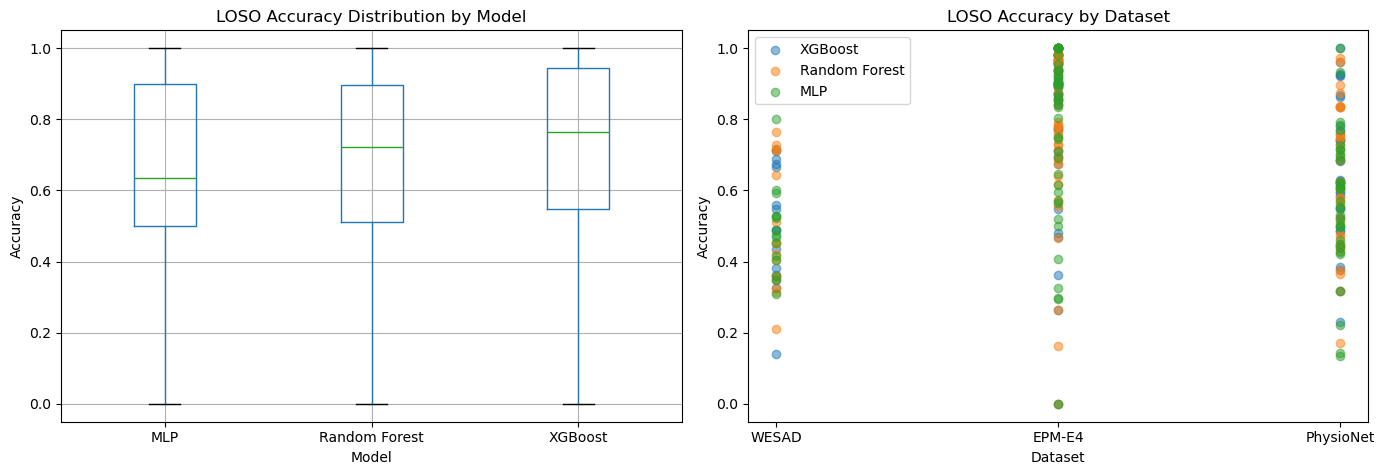

In [17]:
# LOSO accuracy distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot per model
loso_df.boxplot(column='accuracy', by='model', ax=axes[0])
axes[0].set_title('LOSO Accuracy Distribution by Model')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
plt.suptitle('')

# Accuracy distribution by dataset
for model_name in top_models:
    model_data = loso_df[loso_df['model'] == model_name]
    axes[1].scatter(model_data['dataset'], model_data['accuracy'], alpha=0.5, label=model_name)
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('LOSO Accuracy by Dataset')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'loso_accuracy_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# Save hyperparameters of best models
best_params = {}
for name in models:
    model = joblib.load(MODELS_PATH / f'{name.lower().replace(" ", "_")}.pkl')
    best_params[name] = model.get_params()

with open(MODELS_PATH / 'best_hyperparameters.json', 'w') as f:
    # Convert to JSON-serializable format
    params_clean = {}
    for name, params in best_params.items():
        params_clean[name] = {k: str(v) if not isinstance(v, (int, float, str, bool, type(None))) else v 
                              for k, v in params.items()}
    json.dump(params_clean, f, indent=2)

print("Saved: best_hyperparameters.json")

Saved: best_hyperparameters.json


In [19]:
# Save label encoder
joblib.dump(le, MODELS_PATH / 'label_encoder.pkl')

# LOSO performance summary
summary_text = f"""LOSO Performance Summary
========================

Total subjects: {len(subjects)}
Models evaluated: {', '.join(top_models)}

Results:
"""
for model_name in top_models:
    model_data = loso_df[loso_df['model'] == model_name]
    summary_text += f"\n{model_name}:\n"
    summary_text += f"  Mean Accuracy: {model_data['accuracy'].mean():.4f} (+/- {model_data['accuracy'].std():.4f})\n"
    summary_text += f"  Min: {model_data['accuracy'].min():.4f}, Max: {model_data['accuracy'].max():.4f}\n"
    summary_text += f"  Mean F1: {model_data['f1'].mean():.4f}\n"

with open(OUTPUT_PATH / 'loso_performance_summary.txt', 'w') as f:
    f.write(summary_text)
print(summary_text)

LOSO Performance Summary

Total subjects: 96
Models evaluated: XGBoost, Random Forest, MLP

Results:

XGBoost:
  Mean Accuracy: 0.7242 (+/- 0.2385)
  Min: 0.0000, Max: 1.0000
  Mean F1: 0.7595

Random Forest:
  Mean Accuracy: 0.6890 (+/- 0.2367)
  Min: 0.0000, Max: 1.0000
  Mean F1: 0.7333

MLP:
  Mean Accuracy: 0.6615 (+/- 0.2366)
  Min: 0.0000, Max: 1.0000
  Mean F1: 0.7172



In [20]:
# Final summary
print("="*60)
print("STEP 4 COMPLETE: Training and Validation")
print("="*60)
print(f"\nModels trained: {len(models)}")
print(f"\nBest model (CV): {results_df.iloc[0]['model']}")
print(f"  Accuracy: {results_df.iloc[0]['cv_accuracy_mean']:.4f}")
print(f"  F1-score: {results_df.iloc[0]['f1_weighted']:.4f}")
print(f"\nLOSO Validation (best model):")
best_loso = loso_df[loso_df['model'] == results_df.iloc[0]['model']]
print(f"  Mean accuracy: {best_loso['accuracy'].mean():.4f}")
print(f"  Std: {best_loso['accuracy'].std():.4f}")
print(f"\nOutputs saved:")
print(f"  - model_comparison_results.csv")
print(f"  - loso_results.csv")
print(f"  - confusion_matrices/")
print(f"  - trained_models/*.pkl")
print("="*60)

STEP 4 COMPLETE: Training and Validation

Models trained: 8

Best model (CV): XGBoost
  Accuracy: 0.9513
  F1-score: 1.0000

LOSO Validation (best model):
  Mean accuracy: 0.7242
  Std: 0.2385

Outputs saved:
  - model_comparison_results.csv
  - loso_results.csv
  - confusion_matrices/
  - trained_models/*.pkl
